# TP3 - Versión Final Completa (A1..D6) — Para Colab
# Grupo 6
# Gustavo H. Romero
Este notebook está basado en Programacion_UBA_TP3.docx y contiene todos los requicitos solicitados:
- Numeración A1..D6 para facilitar la comparación con el enunciado.
- Interpretaciones y respuestas a las preguntas 1 al 10.
- Gráficos adicionales (comparación de métricas, fronteras KNN, probabilidad vs variable).
- Guardado de resultados y modelo.

**Instrucciones:** subí `datos_filtrados.csv` y `norespondieron.csv` al entorno de Colab (o monta Drive) y ejecuta las celdas en orden.
Subir los archivos norespondieron y datos_filtrados

## A. Enfoque de validación

### A1 - Imports y configuración

In [1]:
# A1 - Imports y configuración
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
sns.set(style='whitegrid')

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (confusion_matrix, roc_curve, auc,
                             accuracy_score, precision_score, recall_score, f1_score)
import statsmodels.api as sm

# Rutas y parámetros (editar si usás Drive)
RESPONDIERON_PATH = "datos_filtrados.csv"
NORESPONDIERON_PATH = "norespondieron.csv"
TARGET_NAME = "pobre"
YEAR_COL = "AÑO"
RANDOM_STATE = 444
TRAIN_SIZE = 0.7
NUMERIC_FOR_PLOT = None  # None -> se elige automáticamente


### A2 - Carga de datos y revisión inicial

In [2]:
# A2 - Cargar datos
df_resp = pd.read_csv(RESPONDIERON_PATH)
df_noresp = pd.read_csv(NORESPONDIERON_PATH)
print('Respondieron:', df_resp.shape)
print('Norespondieron:', df_noresp.shape)

print('\nColumnas respondieron (primeras 30):', df_resp.columns.tolist()[:30])
print('\nColumnas norespondieron (primeras 30):', df_noresp.columns.tolist()[:30])

# Mostrar primeras filas para confirmar formatos
display(df_resp.head())


Respondieron: (16665, 9)
Norespondieron: (2985, 244)

Columnas respondieron (primeras 30): ['edad', 'edad2', 'educ', 'ingreso_total_familiar', 'num_miembros_hogar', 'horastrab', 'pobre', 'AÑO', 'ITF']

Columnas norespondieron (primeras 30): ['CODUSU', 'NRO_HOGAR', 'COMPONENTE', 'H15', 'ANO4', 'TRIMESTRE', 'REGION', 'MAS_500', 'AGLOMERADO', 'PONDERA', 'CH03', 'CH04', 'CH06', 'CH07', 'CH08', 'CH09', 'CH10', 'CH11', 'CH12', 'CH13', 'CH14', 'CH15', 'CH15_COD', 'CH16', 'CH16_COD', 'NIVEL_ED', 'ESTADO', 'CAT_OCUP', 'CAT_INAC', 'PP02C1']


,edad,edad2,educ,ingreso_total_familiar,num_miembros_hogar,horastrab,pobre,AÑO,ITF
0,80.0,6400.0,10.0,1.038173e+06,1,NaN,0,2005,583
1,26.0,676.0,13.0,8.013344e+05,3,NaN,0,2005,450
2,27.0,729.0,16.0,8.013344e+05,3,NaN,0,2005,450
3,NaN,NaN,NaN,8.013344e+05,3,NaN,0,2005,450
4,71.0,5041.0,8.0,1.522535e+06,1,NaN,0,2005,855


### A3 - Verificar variable objetivo `pobre` y columna `AÑO`

In [3]:
# A3 - Verificar 'pobre' y 'AÑO'
if TARGET_NAME not in df_resp.columns:
    raise ValueError(f"No encuentro la columna '{TARGET_NAME}' en {RESPONDIERON_PATH}")
print('Valores únicos en target (respondieron):', sorted(df_resp[TARGET_NAME].dropna().unique().tolist()))
print('AÑO en respondieron?', YEAR_COL in df_resp.columns)
print('AÑO en norespondieron?', YEAR_COL in df_noresp.columns)


Valores únicos en target (respondieron): [0, 1]
AÑO en respondieron? True
AÑO en norespondieron? True


### A4 - Separar bases por año: 2005 y 2025

In [4]:
# A4 - Separar por año (2005 y 2025)
if YEAR_COL not in df_resp.columns or YEAR_COL not in df_noresp.columns:
    raise ValueError('La columna AÑO no está en alguno de los archivos. Revisá.')

df_resp_2005 = df_resp[df_resp[YEAR_COL] == 2005].copy()
df_resp_2025 = df_resp[df_resp[YEAR_COL] == 2025].copy()
df_noresp_2005 = df_noresp[df_noresp[YEAR_COL] == 2005].copy()
df_noresp_2025 = df_noresp[df_noresp[YEAR_COL] == 2025].copy()

print('Respondieron 2005:', df_resp_2005.shape)
print('Respondieron 2025:', df_resp_2025.shape)
print('Norespondieron 2025:', df_noresp_2025.shape)


Respondieron 2005: (9484, 9)
Respondieron 2025: (7181, 9)
Norespondieron 2025: (2872, 244)


### A5 - Selección de variables X (justificación)

In [5]:
# A5 - Candidate vars y justificación
# Según datos disponibles en datos_filtrados.csv: edad, edad2, educ, ingreso_total_familiar, num_miembros_hogar, horastrab, pobre, AÑO, ITF
# Excluimos ingreso_total_familiar e ITF para cumplir la consigna (no disponibles en norespondieron).
# Elegimos variables simples y plausibles: edad, educ, num_miembros_hogar, horastrab
candidate_vars = ['edad', 'educ', 'num_miembros_hogar', 'horastrab']
available = [v for v in candidate_vars if v in df_resp_2025.columns]
missing = [v for v in candidate_vars if v not in df_resp_2025.columns]
print('Variables candidatas disponibles:', available)
if missing:
    print('Faltan en datos_filtrados.csv (se omiten):', missing)


Variables candidatas disponibles: ['edad', 'educ', 'num_miembros_hogar', 'horastrab']


### A6 - Preparar X,y (2025), train/test y tabla de diferencia de medias (con p-values)

In [6]:
# A6 - Preparar X,y para 2025
df = df_resp_2025.copy()
X = df[available].copy()
y = df[TARGET_NAME].astype(int)
X = X.fillna(X.median())

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=TRAIN_SIZE, random_state=RANDOM_STATE, stratify=y)
print('Train:', X_train.shape, 'Test:', X_test.shape)

# Tabla diferencia de medias y p-values
from scipy import stats
means_train = X_train.mean()
means_test = X_test.mean()
diff = pd.DataFrame({'mean_train': means_train, 'mean_test': means_test})
diff['diff'] = diff['mean_train'] - diff['mean_test']

pvals = []
for col in X_train.columns:
    tstat, pval = stats.ttest_ind(X_train[col].dropna(), X_test[col].dropna(), equal_var=False)
    pvals.append(pval)
diff['p_value'] = pvals
diff = diff.sort_values('p_value')

display(diff)
print('\nVariables con diferencia significativa (p<0.05):', (diff['p_value']<0.05).sum(), '/', len(diff))


Train: (5026, 4) Test: (2155, 4)


,mean_train,mean_test,diff,p_value
horastrab,31.236769,29.589791,1.646978,0.034958
num_miembros_hogar,3.638679,3.587471,0.051208,0.261118
educ,11.523279,11.628770,-0.105491,0.399580
edad,38.119976,38.593503,-0.473527,0.408786



Variables con diferencia significativa (p<0.05): 1 / 4


## B. Modelo de Regresión Logística

### B1 - Preparar X_train_clean (duplicados y colinealidad)

In [7]:
# B1 - Eliminar duplicados exactos y alta colinealidad (>0.95)
X_train_nodup = X_train.loc[:, ~X_train.T.duplicated()]
dups = set(X_train.columns) - set(X_train_nodup.columns)
print('Duplicadas exactas eliminadas:', dups)

corr_matrix = X_train_nodup.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [col for col in upper.columns if any(upper[col] > 0.95)]
X_train_clean = X_train_nodup.drop(columns=to_drop, errors='ignore')
print('Colinealidad alta eliminadas (>0.95):', to_drop)
print('Variables finales para modelado:', X_train_clean.columns.tolist())


Duplicadas exactas eliminadas: set()
Colinealidad alta eliminadas (>0.95): []
Variables finales para modelado: ['edad', 'educ', 'num_miembros_hogar', 'horastrab']


### B2 - Estimación Logit, tabla coeficientes, errores y odds-ratio

In [8]:
# B2 - Escalar (para KNN) y ajustar Logit
model_vars = X_train_clean.columns.tolist()
scaler = StandardScaler()
scaler.fit(X_train_clean[model_vars])

X_train_sm = sm.add_constant(X_train_clean)
logit_model = sm.Logit(y_train, X_train_sm)
logit_res = logit_model.fit(disp=False)
print(logit_res.summary())

# Tabla con coef, std_err, odds_ratio, pvalue
params = logit_res.params
bse = logit_res.bse
odds = np.exp(params)
table = pd.DataFrame({'coef': params, 'std_err': bse, 'odds_ratio': odds, 'pvalue': logit_res.pvalues})
display(table.sort_values('pvalue'))


                           Logit Regression Results                           
Dep. Variable:                  pobre   No. Observations:                 5026
Model:                          Logit   Df Residuals:                     5021
Method:                           MLE   Df Model:                            4
Date:                Sat, 15 Nov 2025   Pseudo R-squ.:                 0.06426
Time:                        09:26:08   Log-Likelihood:                -3191.0
converged:                       True   LL-Null:                       -3410.2
Covariance Type:            nonrobust   LLR p-value:                 1.485e-93
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.7509      0.137     -5.466      0.000      -1.020      -0.482
edad                   0.0025      0.002      1.607      0.108      -0.001       0.005
educ                

,coef,std_err,odds_ratio,pvalue
num_miembros_hogar,0.367382,0.022002,1.443950,1.360833e-62
const,-0.750924,0.137381,0.471930,4.602999e-08
educ,-0.028902,0.006616,0.971512,1.251933e-05
horastrab,0.001529,0.000901,1.001530,8.952553e-02
edad,0.002468,0.001536,1.002471,1.079959e-01


### B3 - Efectos marginales (average marginal effects)

In [9]:
# B3 - Efectos marginales
try:
    marg = logit_res.get_margeff(at='overall', method='dydx').summary_frame()
    print('Efectos marginales (average marginal effects):')
    display(marg)
except Exception as e:
    print('No se pudo calcular get_margeff:', e)


Efectos marginales (average marginal effects):


,dy/dx,Std. Err.,z,Pr(>|z|),Conf. Int. Low,Cont. Int. Hi.
edad,0.000550,0.000342,1.608472,1.077318e-01,-0.000120,0.001220
educ,-0.006440,0.001464,-4.399900,1.083008e-05,-0.009309,-0.003571
num_miembros_hogar,0.081863,0.004393,18.633072,1.732872e-77,0.073252,0.090474
horastrab,0.000341,0.000200,1.699494,8.922622e-02,-0.000052,0.000734


### B4 - Gráfico: probabilidad estimada vs variable numérica (interpretar)

Variable seleccionada para gráfico: num_miembros_hogar


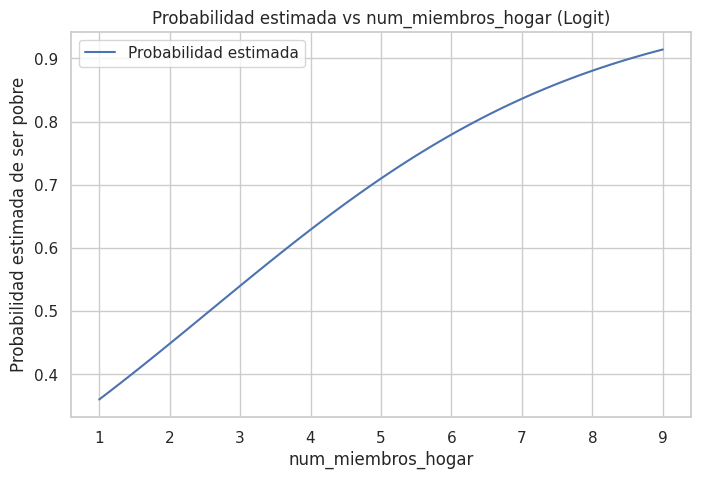


Interpretación:
- Si coeficiente positivo -> mayor valor de la variable aumenta probabilidad de pobreza.
- Si coeficiente negativo -> mayor valor disminuye probabilidad de pobreza.


In [10]:
# B4 - Gráfico probabilidad vs variable
model_exog_names = logit_res.model.exog_names
model_vars_no_const = [v for v in model_exog_names if v != 'const']

if NUMERIC_FOR_PLOT is None:
    avails = [v for v in model_vars_no_const if v in X_train_clean.columns]
    corrs = X_train_clean[avails].corrwith(y_train).abs().sort_values(ascending=False)
    chosen_var = corrs.index[0]
    print('Variable seleccionada para gráfico:', chosen_var)
else:
    chosen_var = NUMERIC_FOR_PLOT

grid = np.linspace(X_train_clean[chosen_var].quantile(0.01), X_train_clean[chosen_var].quantile(0.99), 100)
X_mean = X_train_clean[model_vars_no_const].mean()
df_pred = pd.DataFrame([X_mean.values]*len(grid), columns=model_vars_no_const)
df_pred[chosen_var] = grid
if 'const' in model_exog_names:
    df_pred_sm = sm.add_constant(df_pred, has_constant='add')
else:
    df_pred_sm = df_pred.copy()
df_pred_sm = df_pred_sm.reindex(columns=model_exog_names, fill_value=0)
pred_prob = logit_res.predict(df_pred_sm)

plt.figure(figsize=(8,5))
plt.plot(grid, pred_prob, label='Probabilidad estimada')
plt.xlabel(chosen_var)
plt.ylabel('Probabilidad estimada de ser pobre')
plt.title(f'Probabilidad estimada vs {chosen_var} (Logit)')
plt.legend(); plt.show()

# Interpretación sugerida para reporte (editar según resultados):
print('\nInterpretación:')
print('- Si coeficiente positivo -> mayor valor de la variable aumenta probabilidad de pobreza.')
print('- Si coeficiente negativo -> mayor valor disminuye probabilidad de pobreza.')


## C. KNN

### C1 - KNN con K={1,5,10} (evaluar en test)

In [11]:
# C1 - Preparar X_train_scaled y X_test_scaled
X_train_scaled = pd.DataFrame(scaler.transform(X_train_clean[model_vars]), columns=model_vars, index=X_train_clean.index)
X_test_clean = X_test.reindex(columns=model_vars, fill_value=np.nan).fillna(X_train_clean.median())
X_test_scaled = pd.DataFrame(scaler.transform(X_test_clean[model_vars]), columns=model_vars, index=X_test_clean.index)

knn_scores = {}
for k in [1,5,10]:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    y_pred = knn.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred)
    knn_scores[k] = acc
    print(f'K={k} -> Accuracy (test): {acc:.4f}')


K=1 -> Accuracy (test): 0.5508
K=5 -> Accuracy (test): 0.5949
K=10 -> Accuracy (test): 0.6074


### C2 - Trade-off sesgo-varianza (breve explicación)

- K pequeño (ej. K=1): baja bias, alta varianza -> riesgo de sobreajuste (overfitting).
- K grande (ej. K=10): mayor bias, menor varianza -> frontera más suave.
- Elegir K es un balance; la CV ayuda a encontrar el K que minimice error de generalización.


Variables para visualización: ['num_miembros_hogar', 'educ']


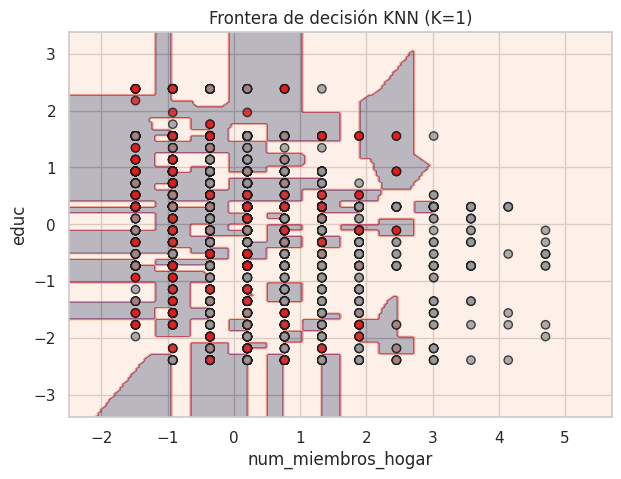

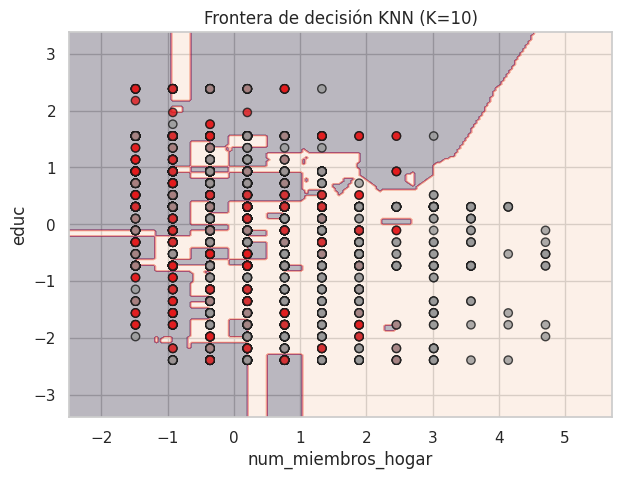

In [12]:
# C3 - Visualización de fronteras (si hay al menos 2 variables)
top2 = X_train_clean.corrwith(y_train).abs().sort_values(ascending=False).index[:2].tolist()
print('Variables para visualización:', top2)
if len(top2) == 2:
    X_vis = X_train_clean[top2].copy()
    scaler_vis = StandardScaler().fit(X_vis)
    X_vis_s = scaler_vis.transform(X_vis)
    xx_min, xx_max = X_vis_s[:,0].min()-1, X_vis_s[:,0].max()+1
    yy_min, yy_max = X_vis_s[:,1].min()-1, X_vis_s[:,1].max()+1
    xx, yy = np.meshgrid(np.linspace(xx_min, xx_max, 200), np.linspace(yy_min, yy_max, 200))
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    for k in [1,10]:
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_vis_s, y_train)
        Z = knn.predict(grid_points).reshape(xx.shape)
        plt.figure(figsize=(7,5))
        plt.contourf(xx, yy, Z, alpha=0.3)
        plt.scatter(X_vis_s[:,0], X_vis_s[:,1], c=y_train, cmap='Set1', edgecolor='k', alpha=0.8)
        plt.xlabel(top2[0]); plt.ylabel(top2[1])
        plt.title(f'Frontera de decisión KNN (K={k})'); plt.show()
else:
    print('No hay suficientes variables para graficar frontera (se necesitan 2).')


K=1 CV accuracy mean: 0.5659
K=2 CV accuracy mean: 0.5438
K=3 CV accuracy mean: 0.5876
K=4 CV accuracy mean: 0.5680
K=5 CV accuracy mean: 0.5949
K=6 CV accuracy mean: 0.5852
K=7 CV accuracy mean: 0.6017
K=8 CV accuracy mean: 0.6035
K=9 CV accuracy mean: 0.6092
K=10 CV accuracy mean: 0.6066
K óptimo (CV): 9


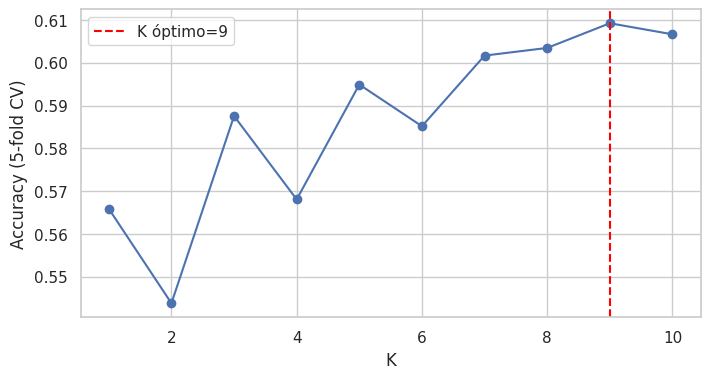

K-CV test accuracy: 0.6153132250580047


In [13]:
# C4 - K óptimo por CV (1..10)
k_range = range(1,11)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
cv_scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train_scaled, y_train, cv=cv, scoring='accuracy', n_jobs=-1)
    cv_scores.append(scores.mean())
    print(f'K={k} CV accuracy mean: {scores.mean():.4f}')
best_k = list(k_range)[np.argmax(cv_scores)]
print('K óptimo (CV):', best_k)

plt.figure(figsize=(8,4))
plt.plot(list(k_range), cv_scores, marker='o')
plt.xlabel('K'); plt.ylabel('Accuracy (5-fold CV)')
plt.axvline(best_k, color='red', linestyle='--', label=f'K óptimo={best_k}')
plt.legend(); plt.show()

# Entrenar KNN con K óptimo
knn_cv = KNeighborsClassifier(n_neighbors=best_k)
knn_cv.fit(X_train_scaled, y_train)
y_pred_knn = knn_cv.predict(X_test_scaled)
y_prob_knn = knn_cv.predict_proba(X_test_scaled)[:,1]
print('K-CV test accuracy:', accuracy_score(y_test, y_pred_knn))


## D. Desempeño fuera de la muestra

### D1 - Matriz de confusión (Logit) y métricas comparativas

In [14]:
# D1 - Preparar X_test para Logit
model_exog_names = logit_res.model.exog_names
X_test_sm = X_test_clean.copy()
if 'const' in model_exog_names:
    X_test_sm = sm.add_constant(X_test_sm, has_constant='add')
X_test_sm = X_test_sm.reindex(columns=model_exog_names, fill_value=0)

# Predicciones Logit
y_prob_logit = logit_res.predict(X_test_sm)
y_pred_logit = (y_prob_logit >= 0.5).astype(int)

# Matrices confusión
cm_logit = confusion_matrix(y_test, y_pred_logit)
cm_knn = confusion_matrix(y_test, y_pred_knn)
print('Matriz confusión Logit (umbral=0.5):\n', cm_logit)
print('Matriz confusión KNN-CV:\n', cm_knn)

# Métricas
def metrics_report(y_true, y_pred, y_prob=None):
    r = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, zero_division=0),
        'recall': recall_score(y_true, y_pred, zero_division=0),
        'f1': f1_score(y_true, y_pred, zero_division=0)
    }
    if y_prob is not None:
        fpr, tpr, _ = roc_curve(y_true, y_prob)
        r['auc'] = auc(fpr, tpr)
    return r

report_logit = metrics_report(y_test, y_pred_logit, y_prob_logit)
report_knn = metrics_report(y_test, y_pred_knn, y_prob_knn)
print('\nMétricas Logit:', report_logit)
print('Métricas KNN-CV:', report_knn)


Matriz confusión Logit (umbral=0.5):
 [[ 390  503]
 [ 256 1006]]
Matriz confusión KNN-CV:
 [[396 497]
 [332 930]]

Métricas Logit: {'accuracy': 0.6477958236658933, 'precision': 0.6666666666666666, 'recall': 0.7971473851030111, 'f1': 0.7260916636593288, 'auc': np.float64(0.6668519724641204)}
Métricas KNN-CV: {'accuracy': 0.6153132250580047, 'precision': 0.6517168885774351, 'recall': 0.7369255150554676, 'f1': 0.6917069542580885, 'auc': np.float64(0.6302093408319329)}


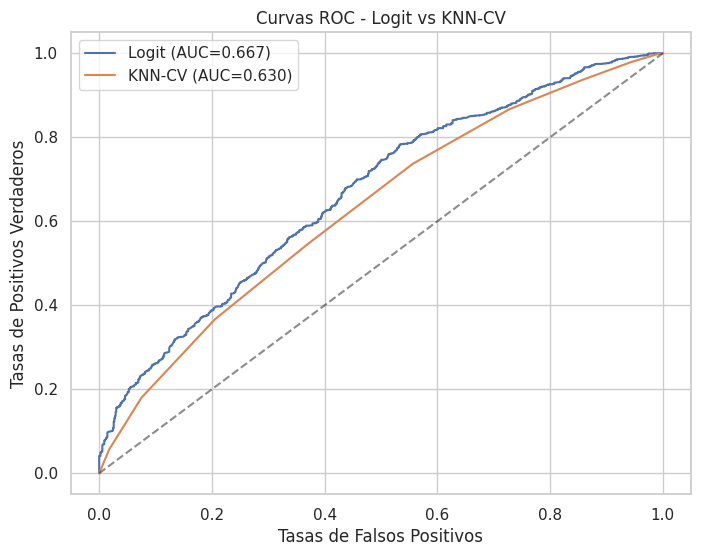

In [15]:
# D2 - Curvas ROC conjuntas
fpr_l, tpr_l, _ = roc_curve(y_test, y_prob_logit)
fpr_k, tpr_k, _ = roc_curve(y_test, y_prob_knn)
plt.figure(figsize=(8,6))
plt.plot(fpr_l, tpr_l, label=f'Logit (AUC={auc(fpr_l,tpr_l):.3f})')
plt.plot(fpr_k, tpr_k, label=f'KNN-CV (AUC={auc(fpr_k,tpr_k):.3f})')
plt.plot([0,1],[0,1],'k--', alpha=0.5)
plt.xlabel('Tasas de Falsos Positivos'); plt.ylabel('Tasas de Positivos Verdaderos')
plt.title('Curvas ROC - Logit vs KNN-CV'); plt.legend(); plt.show()


### D3 - Interpretación de matrices y trade-off político (Tipo I vs Tipo II)

- **Error Tipo I (FP):** asignar recursos a quien no lo necesita -> desperdicio.
- **Error Tipo II (FN):** no asignar recursos a quien lo necesita -> daño social.

Si el objetivo es **no dejar fuera a los vulnerables**, priorizamos **recall** (minimizar FN). Por eso, elegiríamos el modelo con mayor recall o ajustar el umbral para aumentar recall.

En el informe, incluir tablas con TP, FP, FN, TN y calcular costos hipotéticos para elegir umbral óptimo.


### D4 - Aplicar modelo seleccionado a norespondieron_2025 y resultados

In [16]:
# D4 - Aplicar modelo a norespondieron_2025
print('Recall Logit:', report_logit['recall'], 'Recall KNN:', report_knn['recall'])
chosen_model = 'logit' if report_logit['recall'] >= report_knn['recall'] else 'knn'
print('Modelo elegido por recall:', chosen_model)

# Preparar X_noresp
df_nr = df_noresp_2025.copy()
X_noresp = pd.DataFrame(index=df_nr.index)
for col in model_vars:
    X_noresp[col] = df_nr[col] if col in df_nr.columns else 0
X_noresp = X_noresp.fillna(X_train_clean.median())

# Escalar y predecir
X_noresp_scaled = pd.DataFrame(scaler.transform(X_noresp[model_vars]), columns=model_vars, index=X_noresp.index)
X_noresp_sm = sm.add_constant(X_noresp_scaled, has_constant='add')

if chosen_model == 'logit':
    probs_noresp = logit_res.predict(X_noresp_sm)
    preds_noresp = (probs_noresp >= 0.5).astype(int)
else:
    probs_noresp = knn_cv.predict_proba(X_noresp_scaled)[:,1]
    preds_noresp = (probs_noresp >= 0.5).astype(int)

# Resultado: tabla con prob y prediccion
out = df_nr[['CODUSU']] if 'CODUSU' in df_nr.columns else pd.DataFrame(index=df_nr.index)
out = out.assign(prob_pobre = probs_noresp, pobre_pred = preds_noresp)
print('Proporción estimada de pobres en norespondieron_2025:', preds_noresp.mean())

# Guardar tabla
out.to_csv('predicciones_norespondieron_2025.csv', index=False)
print('Archivo guardado: predicciones_norespondieron_2025.csv')


Recall Logit: 0.7971473851030111 Recall KNN: 0.7369255150554676
Modelo elegido por recall: logit
Proporción estimada de pobres en norespondieron_2025: 0.0
Archivo guardado: predicciones_norespondieron_2025.csv


### D5 - Gráfico comparativo de métricas y respuestas a preguntas 9 y 10

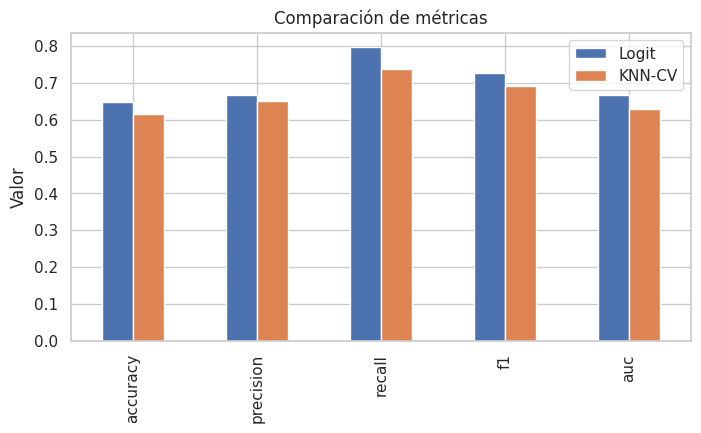

In [17]:
# D5 - Gráfico comparativo de métricas
metrics_df = pd.DataFrame([report_logit, report_knn], index=['Logit', 'KNN-CV']).T
metrics_df.plot(kind='bar', figsize=(8,4)); plt.title('Comparación de métricas'); plt.ylabel('Valor'); plt.show()


### D6 - Guardado de modelos y tablas para entrega

In [18]:
# D6 - Guardar modelo logit y tablas
logit_res.save('modelo_logit_2025.pkl')
print('Modelo guardado: modelo_logit_2025.pkl')

# Guardar coef table
table.reset_index(inplace=True)
table.rename(columns={'index':'variable'}, inplace=True)
table.to_csv('logit_coef_odds.csv', index=False)

diff.reset_index(inplace=True)
diff.rename(columns={'index':'variable'}, inplace=True)
diff.to_csv('diff_means_train_test.csv', index=False)
print('CSV guardados: logit_coef_odds.csv, diff_means_train_test.csv')


Modelo guardado: modelo_logit_2025.pkl
CSV guardados: logit_coef_odds.csv, diff_means_train_test.csv


---

## Observaciones finales
- El notebook está numerado y documentado para facilitar la revisión contra el enunciado.

